In [1]:
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
using Zygote
include("./src/Nevanlinna.jl")

Main.Nevanlinna

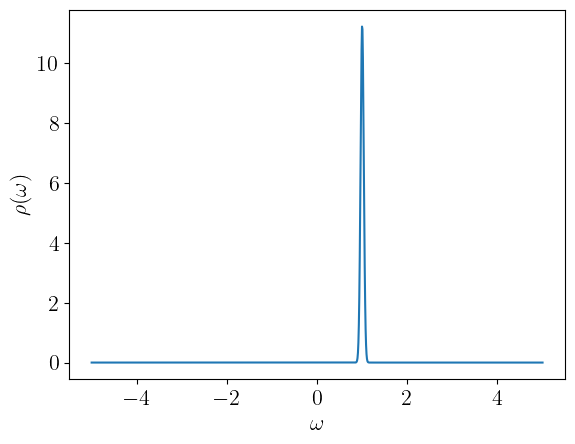

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x152b8b5b7520>

In [2]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

#rho(omega) = gaussian(omega, 1.0, 0.15)
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 
rho(omega) = 1.0*gaussian(omega, 1.0, 0.05) 
#+  0.4*gaussian(omega, 3.0, 0.8) 

omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [4]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

71

In [5]:
setprecision(128)
;

In [6]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [7]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end

In [8]:
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H         =  2
@time result    = Nevanlinna.Nevanlinna_Schur(hnw, test_smpl, test_gw, N_real, omega_max, eta, H, true)
test_real = result[2]
;

N_imag is setted as 5
Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     4.585620e+04     1.504700e+05
 * time: 0.019258975982666016
     1     8.621624e+03     5.151546e+03
 * time: 10.653203964233398
     2     8.097538e+03     4.940913e+03
 * time: 11.476884126663208
     3     1.570100e+03     1.358915e+03
 * time: 12.28088903427124
     4     1.865003e+02     4.736671e+02
 * time: 13.095468997955322
     5     6.871799e+01     2.431479e+02
 * time: 13.913969993591309
     6     1.386286e+01     6.740624e+01
 * time: 14.736129999160767
     7     8.786781e+00     1.597546e+00
 * time: 15.259989023208618
     8     8.542903e+00     7.473171e+00
 * time: 16.081264972686768
     9     8.488411e+00     5.115753e-01
 * time: 16.625205993652344
    10     8.486724e+00     2.836950e-01
 * time: 17.444184064865112
    11     8.465784e+00     3.687649e+00
 * time: 18.788378953933716
    12     7.370309e+00     2.882387e+00
 * time: 20.138808012008667


In [14]:
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 36
ab_coeff  = zeros(Complex{BigFloat}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
pre_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta)

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, pre_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(pre_reals, H)

Nevanlinna.evaluation(pre_reals, abcd, H, ab_coeff, hardy_matrix)
;

N_imag is setted as 5
Pick matrix is positive semi-definite.


In [18]:
tmp =  sum(Float64.(imag.(test_real.val))/pi)*((2.0*test_real.omega_max)/test_real.N_real)
abs(1-tmp)^2

3.966351590056347

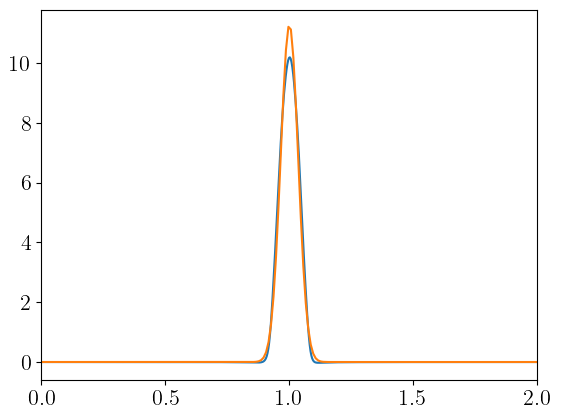

(0.0, 2.0)

In [19]:
plt.plot(Float64.(real.((test_real.freq))), Float64.(imag.(test_real.val))/pi)
plt.plot(omegas, rho.(omegas))
#plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(0.0,2.0)
#plt.ylim(0.0,15)

In [12]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [13]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#